In [50]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.metrics import plot_confusion_matrix

In [51]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
data = pd.read_excel('Anno_final.xlsx', index_col=0)

In [53]:
data

,Id,Comment,Eval
0,1,"Hàng đẹp, tầm giá này thì xài ok,còn chất lượn...",0
1,2,hoàn toàn hài lòng không nặng lắm chỉ là nhìn ...,0
2,3,"Hàng giao nhanh; hàng còn nguyên tem, nhỏ gọn,...",0
3,4,"sản phẩm nhỏ gọn, trông sáng chảnh (sơn bóng l...",0
4,5,Sau 2 ngày đã nhận được hàng. Mình ở tỉnh. Thi...,1
...,...,...,...
395,396,sai cung ok lam nhung k biet co ben hai k phai...,1
396,397,"SP cũng được, nhưng giá thành cao hơn bên....",2
397,398,Cơm hôm nay ăn ngon,1
398,399,Không được chắc.,2


In [54]:
X = data['Comment'].values
y = data['Eval'].values

In [55]:
X[:5]

array(['Hàng đẹp, tầm giá này thì xài ok,còn chất lượng thì thời gian nữa mới biết chính xác vì mới mua.Mong rằng shop làm ăn uy tín đặt chất lượng sản phẩm lên hàng đầu để shop làm ăn ngày càng phát triển.Mọi người nên mua xài.',
       'hoàn toàn hài lòng không nặng lắm chỉ là nhìn ko sang như trong hình của shop nhìn cứ phèn phèn kiểu gì á ngoài mặt thẩm mỹ thì hàng cũng ok',
       'Hàng giao nhanh; hàng còn nguyên tem, nhỏ gọn, hàng mới; chưa dùng nên chưa biết chất lượng như thế nào, sẽ cập nhật tiếp phần chất lượng.',
       'sản phẩm nhỏ gọn, trông sáng chảnh (sơn bóng loáng, có điều nhỏ và mỏng so với trọng lượng nên cầm dể bị tuột rớt,cũng hơi ớn), chất lượng k biết thế nào chứ mẫu mã nhìn không phải hàng giả (ghi power bank),',
       'Sau 2 ngày đã nhận được hàng. Mình ở tỉnh. Thiết kế đẹp. Xài lâu mới biết thế nào. Có vẻ sạc không nhanh lắm. Không biết do điện thoại hay Cục sạc nữa. Mình Xz1'],
      dtype=object)

In [56]:
y[:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [57]:
data['Eval'].value_counts()

0    159
2    143
1     98
Name: Eval, dtype: int64

<AxesSubplot:xlabel='Eval', ylabel='count'>

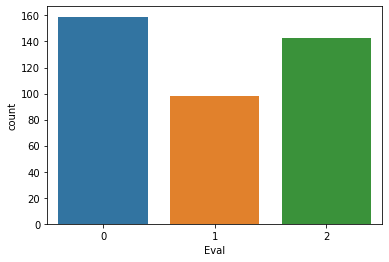

In [58]:
sns.countplot(data=data, x='Eval')

In [59]:
# link stopword: https://www.kaggle.com/code/mpwolke/vietnamese-stopwords-w2v/data?select=vietnamese.txt
stopword_list = pd.read_csv('stopword_vietnamese.csv', names=['stopword'])
stopword_list

,stopword
0,a lô
1,a ha
2,ai
3,ai ai
4,ai nấy
...,...
1938,ừ nhé
1939,ừ thì
1940,ừ ào
1941,ừ ừ


In [60]:
# preprocesing
from pyvi import ViTokenizer
import re

def Preprocessing(string):
  # Xóa các ký tự kéo dài: vd: đẹpppppp
  string = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), string, flags=re.I)
  string = string.lower()

  # link
  string = re.sub('<.*?', '', string).strip()
  string = re.sub('(\s)+', r'\1', string)

  # xóa ký tự đặc biệt
  string = re.sub(r"[-()\\\"#/@;:<>{}`+=~|.!?,%/]", "", string)
  string = re.sub('\n', ' ', string)

  # Loại bỏ stop-word
  string = " ".join([word for word in string.split() if word not in stopword_list])

  # Loại bỏ Emoji
  emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                            "]+", flags=re.UNICODE)
  string = emoji_pattern.sub(r'', string)

  return string

In [61]:
for i in range(len(X)):
  X[i] = Preprocessing(X[i])

In [62]:
def CountVector(X_train, X_test, gram=1):
    CV = CountVectorizer(ngram_range=(gram,gram))
    X_train_encode = CV.fit_transform(X_train)
    X_test_encode = CV.transform(X_test)
    return X_train_encode, X_test_encode

In [63]:
def TfldfVector(X_train, X_test, gram=1):
    tfidf = TfidfVectorizer(ngram_range=(gram,gram))
    X_train_encode = tfidf.fit_transform(X_train)
    X_test_encode = tfidf.transform(X_test)
    return X_train_encode, X_test_encode

In [64]:
def show_confusion_matrix(model, X_test_encode, y_test):
    plot_confusion_matrix(model, X_test_encode, y_test, cmap=plt.cm.Greens)  
    plt.show()

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Naive Bayes model with CountVectorizer (1-gram)

              precision    recall  f1-score   support

           0       0.76      0.97      0.85        38
           1       0.70      0.39      0.50        18
           2       0.71      0.62      0.67        24

    accuracy                           0.74        80
   macro avg       0.72      0.66      0.67        80
weighted avg       0.73      0.74      0.72        80



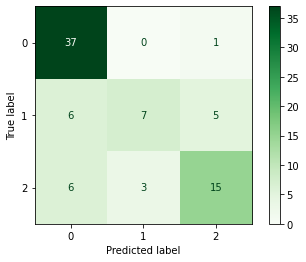

In [66]:
X_train_encode, X_test_encode = CountVector(X_train, X_test, gram=1)
model = MultinomialNB()
model.fit(X_train_encode, y_train)
y_pred = model.predict(X_test_encode)
print(classification_report(y_test, y_pred))
show_confusion_matrix(model, X_test_encode, y_test)

# Naive Bayes model with CountVectorizer (2-gram)

              precision    recall  f1-score   support

           0       0.60      0.87      0.71        38
           1       0.44      0.22      0.30        18
           2       0.69      0.46      0.55        24

    accuracy                           0.60        80
   macro avg       0.58      0.52      0.52        80
weighted avg       0.59      0.60      0.57        80



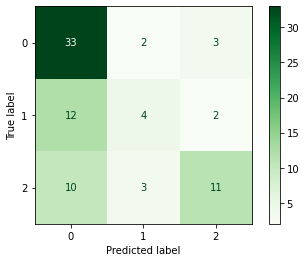

In [67]:
# Naive Bayes model with CountVectorizer (2-gram)
X_train_encode, X_test_encode = CountVector(X_train, X_test, gram=2)
model = MultinomialNB()
model.fit(X_train_encode, y_train)
y_pred = model.predict(X_test_encode)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_encode, y_test, cmap=plt.cm.Greens)  
plt.show()


# Naive Bayes model with TfIdfVectorizer (1-gram)

              precision    recall  f1-score   support

           0       0.74      0.97      0.84        38
           1       1.00      0.28      0.43        18
           2       0.72      0.75      0.73        24

    accuracy                           0.75        80
   macro avg       0.82      0.67      0.67        80
weighted avg       0.79      0.75      0.72        80



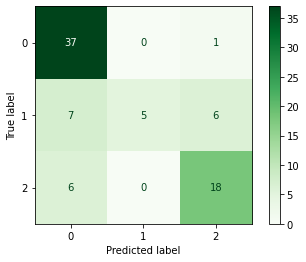

In [68]:
X_train_encode, X_test_encode = TfldfVector(X_train, X_test, gram=1)
model = MultinomialNB()
model.fit(X_train_encode, y_train)
y_pred = model.predict(X_test_encode)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_encode, y_test, cmap=plt.cm.Greens)  
plt.show()

# Naive Bayes model with TfIdfVectorizer (2-gram)

              precision    recall  f1-score   support

           0       0.59      0.89      0.71        38
           1       0.67      0.11      0.19        18
           2       0.58      0.46      0.51        24

    accuracy                           0.59        80
   macro avg       0.61      0.49      0.47        80
weighted avg       0.60      0.59      0.53        80



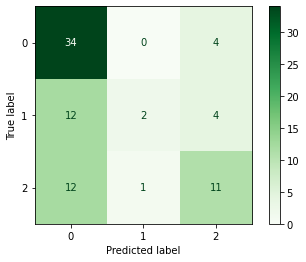

In [69]:
X_train_encode, X_test_encode = TfldfVector(X_train, X_test, gram=2)
model = MultinomialNB()
model.fit(X_train_encode, y_train)
y_pred = model.predict(X_test_encode)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_test_encode, y_test, cmap=plt.cm.Greens)  
plt.show()